# ✅ Lab: Bank Customer Churn Prediction with GridSearchCV

## 🎯 Objectives

- Load and inspect a churn dataset.
- Prepare data for machine learning:
  - Define feature matrix **X** and target vector **y**
  - Encode categorical variables
- Split the dataset into training and testing subsets.
- Compare multiple classification models using **GridSearchCV**.
- Evaluate model performance using:
  - **Accuracy**
  - **Precision (macro)**
  - **Recall (macro)**
  - **F1-score (macro)**
- Visualise the performance of the best-performing model using **confusion matrices**.


## 1️⃣ Imports and Why We Need Them

### Why we do this
We need the core libraries for data analysis (**pandas**, **numpy**), plotting (**matplotlib**), and machine learning (**scikit-learn**).

Warnings are disabled so students can focus on learning concepts rather than non-essential system messages.


In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


## 2️⃣ Reproducibility and Experiment Settings

### Why we do this
- **random_state** ensures that results are repeatable across multiple runs.
- **test_size** controls how much of the dataset is reserved for final model evaluation.
- **cv** defines the number of folds used during cross-validation in GridSearch, balancing robustness and computational cost.


In [8]:
random_state = 42
numpy.random.seed(random_state)

test_size = 0.30
cv = 3

## 3️⃣ Load the Dataset

### Why we do this
We load the CSV file into a DataFrame and inspect the first few rows to verify that the data has been read correctly and to understand the dataset structure.


In [9]:
url = "Bank_Customer_Churn_Prediction.xls"
df = pd.read_csv(url)

df.head()


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 4️⃣ Define Features (X) and Target (y)

### Why we do this
Machine learning models require:
- **X**: input features (predictor variables)
- **y**: target variable (the outcome we want to predict)

The **customer_id** column is removed because it is only an identifier and does not contain predictive information.

### Understanding Churn
**Churn** refers to the situation where a customer stops using a company’s product or service.

In this lab context:
- **Churn = 1** → the customer left the bank  
- **Churn = 0** → the customer stayed with the bank


In [10]:
target = "churn"

X = df.drop(columns=[target, "customer_id"])
y = df[target]

print(y.value_counts())


churn
0    7963
1    2037
Name: count, dtype: int64


## 5️⃣ Encode Categorical Variables

### Why we do this
Machine learning models cannot directly process text-based values such as country names or gender labels.

Categorical features are therefore converted into numerical representations using **one-hot encoding**, allowing the model to learn meaningful patterns from these variables.


In [11]:
# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, columns=["country", "gender"], drop_first=True)

X.head()


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,False,True,False


## 6️⃣ Split Data into Train and Test

### Why we do this
- The **training set** is used for model training and cross-validation.
- The **test set** is kept completely separate for final, unbiased model evaluation.
- **stratify = y** ensures that the proportion of churned and non-churned customers remains consistent in both the training and test datasets.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 7000
Test size: 3000


## 7️⃣ Define Models and Parameter Grids

### Why we do this
We compare multiple classification algorithms and tune their hyperparameters to improve performance.

Each model is assigned a small hyperparameter grid so **GridSearchCV** can systematically test different combinations and identify the best configuration.


In [13]:
models = {
    "Decision Tree": (
        DecisionTreeClassifier(random_state=random_state),
        {"max_depth": range(2, 10), "class_weight": [None, "balanced"]}
    ),
    "Naive Bayes": (
        GaussianNB(),
        {"var_smoothing": [1e-9, 1e-10, 1e-11]}
    ),
    "Perceptron": (
        Perceptron(random_state=random_state),
        {"early_stopping": [True, False], "class_weight": [None, "balanced"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": range(3, 8)}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=random_state),
        {"n_estimators": [10, 20, 30, 40], "learning_rate": [0.5, 1.0, 1.5]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=random_state),
        {"n_estimators": [20, 40], "max_depth": [5, 8]}
    )
}


## 8️⃣ Choose Scoring Metrics

### Why we do this
Churn datasets are often imbalanced, meaning one class may dominate the other.  
Relying on accuracy alone can therefore be misleading.

To obtain a more reliable evaluation, we assess models using:
- **Accuracy**
- **Precision (macro)**
- **Recall (macro)**
- **F1-score (macro)**

Macro-averaging treats all classes equally, making these metrics more suitable for churn prediction.


In [14]:
scorings = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

## 9️⃣ Run GridSearchCV and Store Results

### Why we do this
For each model and each scoring metric:
- **GridSearchCV** is used to find the best hyperparameters through cross-validation.
- The optimised model is then evaluated on the test set.
- Performance metrics are stored in a structured results table for comparison.

### Important fix
Metric column names are stored **exactly** as:
- `precision_macro`
- `recall_macro`
- `f1_macro`

This ensures consistent naming and prevents sorting errors such as `KeyError` during result analysis.


In [15]:
# IMPORTANT: metric column names match the 'scorings' list -> no KeyError
results = pd.DataFrame(columns=[
    "scoring", "model", "best_params",
    "accuracy", "precision_macro", "recall_macro", "f1_macro"
])

trained_models = []  # aligned with rows in results

for scoring in scorings:
    for model_name, (estimator, params) in models.items():

        clf = GridSearchCV(
            estimator=estimator,
            param_grid=params,
            scoring=scoring,
            cv=cv
        )

        clf.fit(X_train, y_train)
        trained_models.append(clf)

        y_pred = clf.predict(X_test)

        cr = classification_report(
            y_test, y_pred,
            output_dict=True,
            zero_division=1 
        )

        results.loc[len(results)] = [
            scoring,
            model_name,
            clf.best_params_,
            cr["accuracy"],
            cr["macro avg"]["precision"],
            cr["macro avg"]["recall"],
            cr["macro avg"]["f1-score"]
        ]

results.head()


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
0,accuracy,Decision Tree,"{'class_weight': None, 'max_depth': 5}",0.859667,0.833625,0.693852,0.731429
1,accuracy,Naive Bayes,{'var_smoothing': 1e-11},0.828667,0.764051,0.629319,0.655158
2,accuracy,Perceptron,"{'class_weight': None, 'early_stopping': True}",0.222000,0.503024,0.500548,0.197901
3,accuracy,KNN,{'n_neighbors': 6},0.785000,0.530852,0.504456,0.467164
4,accuracy,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 30}",0.857000,0.801376,0.716539,0.745641


## 🔟 Display Best Models for Each Metric

### Why we do this
We present a clean, organised table showing how models rank under each evaluation metric.

For each scoring metric, results are sorted by the corresponding score, allowing us to clearly identify the best-performing model depending on the optimisation criterion.


In [16]:
for score in scorings:
    display(
        results[results["scoring"] == score]
        .sort_values(by=score, ascending=False)   # <-- now this column exists
        .drop(columns="scoring")
        .style.format(precision=3)
        .set_caption(f"Best models by {score}")
    )

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
5,Random Forest,"{'max_depth': 8, 'n_estimators': 40}",0.868,0.853,0.708,0.748
0,Decision Tree,"{'class_weight': None, 'max_depth': 5}",0.860,0.834,0.694,0.731
4,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 30}",0.857,0.801,0.717,0.746
1,Naive Bayes,{'var_smoothing': 1e-11},0.829,0.764,0.629,0.655
3,KNN,{'n_neighbors': 6},0.785,0.531,0.504,0.467
2,Perceptron,"{'class_weight': None, 'early_stopping': True}",0.222,0.503,0.501,0.198


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
10,AdaBoost,"{'learning_rate': 0.5, 'n_estimators': 20}",0.812,0.877,0.540,0.522
11,Random Forest,"{'max_depth': 5, 'n_estimators': 20}",0.844,0.849,0.634,0.666
6,Decision Tree,"{'class_weight': None, 'max_depth': 5}",0.860,0.834,0.694,0.731
7,Naive Bayes,{'var_smoothing': 1e-11},0.829,0.764,0.629,0.655
8,Perceptron,"{'class_weight': 'balanced', 'early_stopping': True}",0.501,0.548,0.572,0.476
9,KNN,{'n_neighbors': 5},0.761,0.515,0.506,0.488


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
12,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 6}",0.774,0.700,0.777,0.715
16,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 20}",0.854,0.786,0.729,0.751
17,Random Forest,"{'max_depth': 8, 'n_estimators': 40}",0.868,0.853,0.708,0.748
13,Naive Bayes,{'var_smoothing': 1e-11},0.829,0.764,0.629,0.655
14,Perceptron,"{'class_weight': 'balanced', 'early_stopping': True}",0.501,0.548,0.572,0.476
15,KNN,{'n_neighbors': 5},0.761,0.515,0.506,0.488


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
23,Random Forest,"{'max_depth': 8, 'n_estimators': 40}",0.868,0.853,0.708,0.748
18,Decision Tree,"{'class_weight': None, 'max_depth': 7}",0.858,0.805,0.717,0.746
22,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 40}",0.859,0.822,0.702,0.737
19,Naive Bayes,{'var_smoothing': 1e-11},0.829,0.764,0.629,0.655
21,KNN,{'n_neighbors': 3},0.736,0.513,0.508,0.502
20,Perceptron,"{'class_weight': 'balanced', 'early_stopping': True}",0.501,0.548,0.572,0.476


## 1️⃣1️⃣ Confusion Matrix for the Best Model

### Why we do this
Metrics such as accuracy and F1-score alone do not fully explain model behaviour.

A **confusion matrix** provides a detailed breakdown of predictions, showing:
- **True Positives** and **True Negatives**
- **False Positives** and **False Negatives**

In churn prediction, **false negatives** (failing to identify customers who will leave) are often particularly costly, making the confusion matrix a critical evaluation tool.


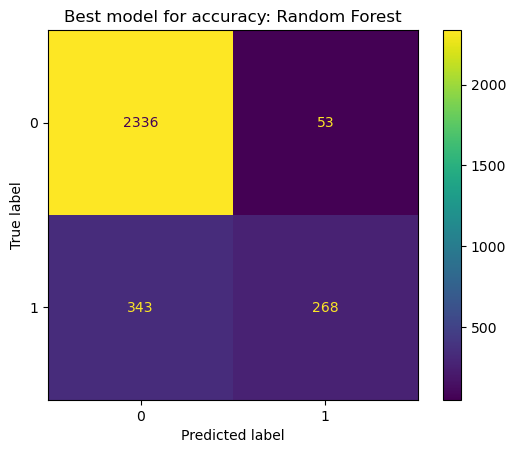

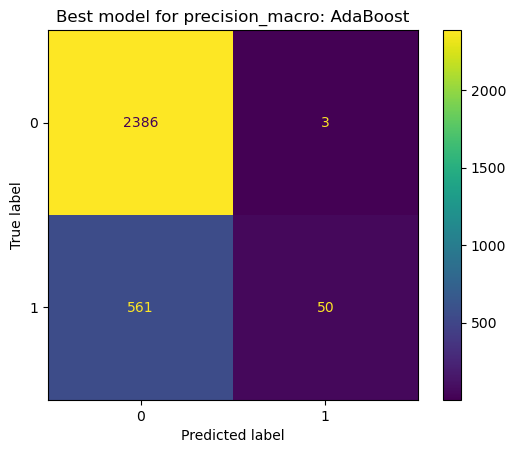

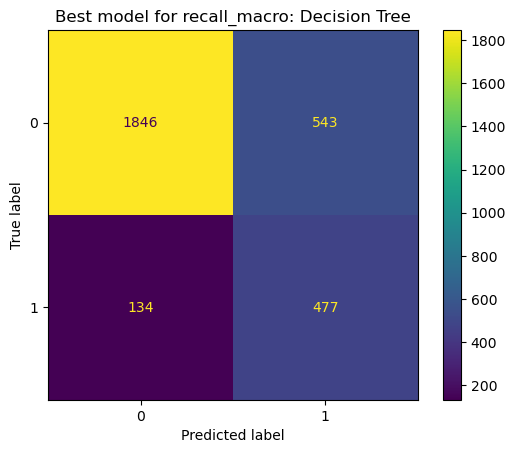

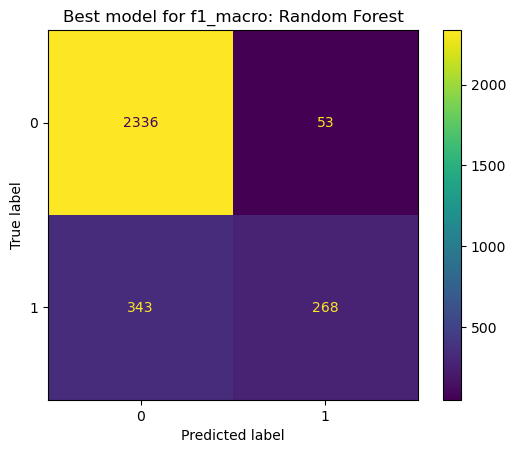

In [17]:
for score in scorings:
    sub = results[results["scoring"] == score]
    best_row = sub[score].idxmax()  # index in the full results DataFrame

    best_clf = trained_models[best_row]
    best_name = results.loc[best_row, "model"]

    disp = ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test)
    disp.ax_.set_title(f"Best model for {score}: {best_name}")
    plt.show()

## 📊 Interpreting Confusion Matrices Under Different Optimisation Criteria

These four figures are confusion matrices of the **best model selected under different optimisation metrics**.  
They are **not contradictory** — they demonstrate how changing the optimisation metric changes model behaviour.

Below is a clear, teaching-oriented interpretation.

---

## 🔍 How to Read a Confusion Matrix (Very Important)

For **churn prediction**:

- **Class 0** → customer stays  
- **Class 1** → customer churns  

Confusion matrix layout:

|              | Predicted 0 | Predicted 1 |
|--------------|-------------|-------------|
| **True 0**   | TN          | FP          |
| **True 1**   | FN          | TP          |

Where:
- **TN** = correctly predicted non-churners  
- **TP** = correctly predicted churners  
- **FP** = false alarm (predicted churn but customer stayed)  
- **FN** = missed churner (**dangerous in business**)  

---

## 1️⃣ Best Model for **Accuracy** → Random Forest

- **TN = 2336**, **FP = 53**  
- **FN = 343**, **TP = 268**

### What this means
- Very strong at predicting customers who stay.
- Misses many churners (343 false negatives).
- High accuracy mainly because most customers do not churn.

### Interpretation
Accuracy favours the **majority class** (non-churners).

### Teaching takeaway
- ✔ Good for overall correctness  
- ❌ Poor if missing churners is costly  

---

## 2️⃣ Best Model for **Precision (macro)** → AdaBoost

- **TN = 2386**, **FP = 3**  
- **FN = 561**, **TP = 50**

### What this means
- Almost no false positives.
- When it predicts churn, it is usually correct.
- Extremely conservative: predicts churn very rarely.
- Misses most churners.

### Interpretation
Precision optimisation avoids **false alarms at all costs**.

### Teaching takeaway
- ✔ Good when false positives are expensive  
- ❌ Very poor for churn detection  

---

## 3️⃣ Best Model for **Recall (macro)** → Decision Tree

- **TN = 1846**, **FP = 543**  
- **FN = 134**, **TP = 477**

### What this means
- Catches most churners (low FN).
- Generates many false alarms.
- Aggressive churn prediction behaviour.

### Interpretation
Recall optimisation prioritises **“do not miss churners”**.

### Teaching takeaway
- ✔ Best when losing a customer is very costly  
- ❌ Many unnecessary retention actions  

---

## 4️⃣ Best Model for **F1-macro** → Random Forest

- **TN = 2336**, **FP = 53**  
- **FN = 343**, **TP = 268**

### What this means
- Balanced trade-off between precision and recall.
- Same confusion matrix as the accuracy winner in this case.
- Moderate churn detection with moderate false alarms.

### Interpretation
F1-score balances catching churners and avoiding false alarms.

### Teaching takeaway
- ✔ Strong compromise model  
- ✔ Commonly preferred in real ML systems  

---

## 🔑 Big Picture — Core Lesson

Why do we get **different best models**?

Because **each metric answers a different question**:

| Metric    | Question it answers |
|----------|---------------------|
| Accuracy | How often am I correct overall? |
| Precision | When I predict churn, am I right? |
| Recall | How many churners did I catch? |
| F1 | What is the best balance? |

---

## 🏦 Business Interpretation (Very Important)

In banking:
- **Missing a churner** = lost customer  
- **False positives** = cost of a retention offer  

Therefore:
- **Recall** or **F1** is often more appropriate than accuracy alone.

---

## 🧠 One-Sentence Classroom Summary

The “best” model depends on what we care about: overall correctness, avoiding false alarms, catching churners, or balancing both.


## ⚒️Simple extension of the exercise

Try to extend this exercise adding to the metrics the `custom_scorer` that was introduced in Lab_04

## ✅ Outcomes

After completing this lab, students will be able to:

- Prepare a dataset for classification by defining **X/y** and applying appropriate encoding techniques.
- Use **GridSearchCV** to tune model hyperparameters effectively.
- Compare multiple classifiers using different scoring metrics.
- Select the best-performing model and interpret its behaviour using **confusion matrices**.
